In [1]:
import os
import xarray as xr
import numpy as np
from netCDF4 import Dataset
from collections import defaultdict
from wrf import getvar, ALL_TIMES, interplevel, to_np, latlon_coords, get_cartopy, extract_times, ll_to_xy, to_np
from functions.listwrfouts import listWrfouts
from functions.injectmissincoords import inject_missing_coordinates_from_geo_em
from functions.plots import *
from functions.get_point_data import get_point_data
from functions.get_physics import get_mp_and_pbl
from functions.errors import *
from functools import partial
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from matplotlib import cm
from matplotlib.colors import to_hex
import cartopy.crs as ccrs
import gc
import pandas as pd
from matplotlib.colors import BoundaryNorm
import cmaps
from datetime import timedelta
import matplotlib.dates as mdates
import re
import imageio.v2 as imageio
import skill_metrics as sm
import glob
from pathlib import Path

In [5]:
def process_set(set_name, base_dir, geo_em_base):
    archive_path = os.path.join(base_dir, set_name, f"{set_name}_wrfouts.tar.gz")
    extract_dir = os.path.join(base_dir, set_name, "temp_extract_dir")

    files = listWrfouts(archive_path, extract_dir)
    print(f"Listing wrfouts from {archive_path}")
    domain_files = defaultdict(list)
    for f in files:
        if "d01" in os.path.basename(f):
            domain_files["d01"].append(f)
        elif "d02" in os.path.basename(f):
            domain_files["d02"].append(f)

    result = defaultdict(list)
    print(f"Listed wrfouts from {archive_path}")

    for dom in domain_files:
        domain_files[dom] = sorted(domain_files[dom])
        geo_em_path = os.path.join(geo_em_base, f"geo_em.{dom}.nc")
        for file in domain_files[dom]:
            print(f"Injecting missing values into {file}, from {geo_em_path}")
            inject_missing_coordinates_from_geo_em(file, geo_em_path)
        result[dom] = [Dataset(path, mode="r") for path in domain_files[dom]]

    return set_name, result

# Read WRF outputs 

In [ ]:
case = "20012024"
base_dir = os.path.join(r"D:\istanbul_wrfouts", case)
sets = [f"SET{i}" for i in range(1, 16)]
df = {}

for set in sets:
    df[set] = {}
    wrfouts_list = listWrfouts(os.path.join(base_dir, set, f"{set}_wrfouts.tar.gz"), os.path.join(base_dir, set, "temp_extract_dir"))
    for f in wrfouts_list:
        if "d01" in os.path.basename(f):
            df[set]["d01"] = Dataset(f)
            gc.collect()
        elif "d02" in os.path.basename(f):
            df[set]["d02"] = Dataset(f)
            gc.collect()

for domain in ["d01", "d02"]:
    for i in range(72):
        plot_PRECIP_15facet(df, domain, i, levels = [0.1, 0.2, 0.5, 1, 2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50], fig_path = os.path.join(os.getcwd(), "figures", case, "hourly_precip", domain))

d:\miniconda3\envs\mto\lib\site-packages\wrf\util.py:1324: UserWarning: WARNING: _FillValue not used since it
cannot be safely cast to variable data type
  lat_coord_vals = lat_var[:]


# Read CSV files

In [ ]:
case = "20241123"
station_id = "17061"
csv_files_path = os.path.join(os.getcwd(), "csv_files")

matching_files = []
df = {}

if os.path.isdir(csv_files_path):
    for filename in os.listdir(csv_files_path):
        if filename.startswith(f"case_{case}") and filename.endswith(f"{station_id}.csv"):
            matching_files.append(os.path.join(csv_files_path, filename))

for file in matching_files:
    physics = file.split(f"case_{case}")[1].split("_station")[0].lstrip("_")
    set_name = sets_mapping.loc[sets_mapping["physics"] == physics, "set_name"].values[0]
    df[set_name] = pd.read_csv(file)

In [ ]:
for domain in ["d01", "d02"]:
    for i in range(72):
        plot_PRECIP_15facet(df, domain, i, levels = [0.1, 0.2, 0.5, 1, 2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50], fig_path = os.path.join(os.getcwd(), "figures", "02112023", "hourly_precip", domain))

In [ ]:
base_dir = r"E:\29112023"
sets = [f"SET{i}" for i in range(1, 2)]
df = {}

for set in sets:
    df[set] = {}
    wrfouts_list = listWrfouts(os.path.join(base_dir, set, f"{set}_wrfouts.tar.gz"), os.path.join(base_dir, set, "temp_extract_dir"))
    for f in wrfouts_list:
        if "d01" in os.path.basename(f):
            df[set]["d01"] = Dataset(f)
            gc.collect()
        elif "d02" in os.path.basename(f):
            df[set]["d02"] = Dataset(f)
            gc.collect()

In [ ]:
set_name = "SET1"
levels = [0.1, 0.2, 0.5, 1, 2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
for domain in ["d01", "d02"]:
    for timestep in range(72):
        fig = plt.figure(figsize=(20, 12)) 
        ds = df[set_name][domain]

        tp = getvar(ds, "RAINC", timeidx=ALL_TIMES) + getvar(ds, "RAINNC", timeidx=ALL_TIMES)
        tp_deacc = tp.diff(dim='Time', label='upper')
        lats, lons = latlon_coords(getvar(ds, "RAINC"))
        proj = get_cartopy(getvar(ds, "RAINC"))
        ax = plt.axes(projection=proj)
        ax.coastlines()

        ax.set_title(f"Hourly Precipitation", fontsize=18)

        contourf = ax.contourf(to_np(lons), to_np(lats), to_np(tp_deacc.isel(Time=timestep)), transform = ccrs.PlateCarree(), extend="max", levels = levels, cmap = cmaps.precip2_17lev)

        cbar = fig.colorbar(contourf, ax=ax, orientation='horizontal', ticks=levels, extend="max", shrink=.5)
        cbar.set_label("mm", fontsize=18)
        cbar.ax.tick_params(labelsize=16)

        ax.set_title(f"{pd.Timestamp(extract_times(ds, timeidx=timestep)).strftime('%d/%m/%Y %HZ')}", fontsize=14, loc='left')
        os.makedirs(os.path.join(os.getcwd(), "test", domain), exist_ok=True)
        fig.savefig(os.path.join(os.getcwd(), "test", domain, f"{timestep}.png"), format="png")
        plt.close()

In [ ]:
domain = "d01"
timestep = 0
set_name = "SET1"

fig = plt.figure(figsize=(4, 2.3), layout="compressed") 
ds = df[set_name][domain]

tp = getvar(ds, "RAINC", timeidx=ALL_TIMES) + getvar(ds, "RAINNC", timeidx=ALL_TIMES)
tp_deacc = tp.diff(dim='Time', label='upper')
lats, lons = latlon_coords(getvar(ds, "RAINC"))
proj = get_cartopy(getvar(ds, "RAINC"))
ax = plt.axes(projection=proj)
ax.coastlines()

ax.set_title(f"Hourly Precipitation\n{pd.Timestamp(extract_times(ds, timeidx=timestep)).strftime('%d/%m/%Y %HZ')}", fontsize=7)

contourf = ax.contourf(to_np(lons), to_np(lats), to_np(tp_deacc.isel(Time=timestep)), transform = ccrs.PlateCarree(), extend="max", levels = levels, cmap = cmaps.precip2_17lev)

cbar = fig.colorbar(contourf, ax=ax, orientation='horizontal', ticks=levels, extend="max", shrink=1)
cbar.set_label("mm", fontsize=5)
cbar.ax.tick_params(labelsize=3)

os.makedirs(os.path.join(os.getcwd(), "test", domain), exist_ok=True)
fig.savefig(os.path.join(os.getcwd(), "test", domain, f"{timestep}.png"), format="png")
plt.close()

# Handle Observation Data

In [ ]:
import re
import sys
from pathlib import Path
import calendar
import pandas as pd
from openpyxl import load_workbook

In [ ]:
import re
from pathlib import Path
from typing import Optional, Tuple

import numpy as np
import pandas as pd


def parse_mgm_hourlies(
    xlsx_path: str | Path,
    out_dir: str | Path = "out",
    *,
    sheet_name: int | str = 0,
    verbose: bool = False,
) -> list[Path]:
    """
    Parse Turkish MGM hourly-observation workbooks and write one CSV per
    (year, month, station, variable).  Wind tables keep both direction & speed.

    Returns
    -------
    list[Path]          Paths of the CSVs written or updated.
    """
    xlsx_path = Path(xlsx_path)
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    # ------------------------------------------------------------------ #
    # 1. Load sheet (raw strings, no header detection)
    # ------------------------------------------------------------------ #
    df = pd.read_excel(
        xlsx_path, sheet_name=sheet_name, header=None, engine="openpyxl", dtype=str
    )

    # ------------------------------------------------------------------ #
    # 2. Look-ups
    # ------------------------------------------------------------------ #
    var_lookup = {
        "Deniz Seviyesine İndirgenmiş Basınç": ("mslp", "hPa"),
        "İşba Sıcaklığı": ("td2", "degC"),
        "Rüzgar Yönü": ("wdir_ws", "deg_mps"),
        "Sıcaklık": ("t2", "degC"),
        "Toplam Yağış": ("precip", "mm"),
    }

    meta_re = re.compile(
        r"Yıl/Ay:\s*(\d{4})/(\d{1,2})\s+İstasyon Adı/No:\s*[^/]+/(\d+)"
    )

    # ------------------------------------------------------------------ #
    # 3. State variables
    # ------------------------------------------------------------------ #
    current: dict[str, str | int] = {}
    buffer: list[dict[str, str]] = []
    files_written: list[Path] = []

    # ------------------------------------------------------------------ #
    # Helper: split wind cell → (direction, speed)
    # ------------------------------------------------------------------ #
    _num_re = re.compile(r"\d+(?:[.,]\d+)?")

    def _split_wind_cell(cell: str) -> Tuple[Optional[float], Optional[float]]:
        """Return (direction, speed) with None when missing."""
        nums = _num_re.findall(cell.replace(",", "."))
        if not nums:
            return None, None

        nums = [float(n) for n in nums]
        if len(nums) == 2:                    # “140 3.2”
            return nums[0], nums[1]

        num = nums[0]
        if 0 <= num <= 360:
            return num, None                 # direction only
        return None, num                     # speed only

    # ------------------------------------------------------------------ #
    # Helper: write or append a completed table
    # ------------------------------------------------------------------ #
    def flush_buffer() -> None:
        nonlocal buffer
        if not buffer or "var" not in current:
            buffer.clear()
            return

        # wide → long
        tmp = pd.DataFrame(buffer).melt(
            id_vars="day", var_name="hour", value_name="raw"
        )
        tmp["raw"] = (
            tmp["raw"].replace(",", ".", regex=False)
            .fillna("")
            .astype(str)
            .str.strip()
        )

        if current["var"] == "wdir_ws":
            tmp[["wdir", "value"]] = tmp["raw"].apply(_split_wind_cell).tolist()
            tmp = tmp.dropna(subset=["wdir", "value"], how="all")
        else:
            tmp["value"] = pd.to_numeric(
                tmp["raw"].replace("", np.nan), errors="coerce"
            )
            tmp = tmp.dropna(subset=["value"], how="all")

        if tmp.empty:
            buffer.clear()
            return

        # make timestamps
        y, m = int(current["year"]), int(current["month"])
        tmp["day"] = pd.to_numeric(tmp["day"], errors="coerce").astype("Int64")
        tmp["hour"] = pd.to_numeric(tmp["hour"], errors="coerce").astype("Int64")
        tmp["datetime"] = pd.to_datetime(
            dict(year=y, month=m, day=tmp["day"], hour=tmp["hour"]), errors="coerce"
        )
        tmp = tmp.dropna(subset=["datetime"])

        cols = ["datetime", "value"] + (["wdir"] if "wdir" in tmp.columns else [])
        tmp = tmp[cols].sort_values("datetime")

        # write / append
        fname = (
            f"{y:04d}{m:02d}_{current['var']}_{current['unit']}_{current['station']}.csv"
        )
        path = out_dir / fname
        if path.exists():
            old = pd.read_csv(path, parse_dates=["datetime"])
            tmp = (
                pd.concat([old, tmp], ignore_index=True)
                .drop_duplicates(subset=["datetime"])
                .sort_values("datetime")
            )
        tmp.to_csv(path, index=False, float_format="%.3f")
        files_written.append(path)
        if verbose:
            print(f"✓ {path.name:38s} {len(tmp):4d} rows")

        buffer.clear()

    # ------------------------------------------------------------------ #
    # 4. Walk the sheet
    # ------------------------------------------------------------------ #
    for _, row in df.iterrows():
        cell = next((str(c).strip() for c in row if pd.notna(c) and str(c).strip()), "")
        if not cell:
            continue

        # a) metadata line
        m = meta_re.match(cell)
        if m:
            flush_buffer()
            current = {"year": m[1], "month": m[2], "station": m[3]}
            continue

        # b) variable title
        matched = next(
            ((vcode, unit) for frag, (vcode, unit) in var_lookup.items() if frag in cell),
            None,
        )
        if matched:
            flush_buffer()
            vcode, unit = matched
            current |= {"var": vcode, "unit": unit}
            continue

        # c) header row
        if cell.startswith("Gün/Saat"):
            offset = row.first_valid_index()
            hours = (
                row.iloc[offset + 1 : offset + 1 + 24]
                .astype(str)
                .str.extract(r"(\d+)")
                .dropna()[0]
                .astype(int)
                .tolist()
            )
            current |= {"hours": hours, "offset": offset}
            continue

        # d) data row
        if "var" in current and "hours" in current:
            offset = current["offset"]
            day = pd.to_numeric(row.iloc[offset], errors="coerce")
            if not np.isnan(day):
                vals = row.iloc[offset + 1 : offset + 1 + len(current["hours"])].tolist()
                buffer.append({"day": int(day), **dict(zip(current["hours"], vals))})

    flush_buffer()
    return files_written


In [ ]:
file_path = Path("./obs_data/20250502CA86-Saatlik Rüzgar Yönü (°) ve Hızı (m÷sn).xlsx")
df = pd.read_excel(file_path, engine="openpyxl")   
for i in df["Unnamed: 1"]: print(i)

In [ ]:
file_path

WindowsPath('obs_data/20250502CA86-Saatlik Rüzgar Yönü (°) ve Hızı (m÷sn).xlsx')

In [ ]:
files = parse_mgm_hourlies(
    file_path,
    out_dir=".",
    verbose=True,
)

d:\miniconda3\envs\mto\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


✓ 202001_wdir_ws_deg_mps_17610.csv        744 rows
✓ 202001_wdir_ws_deg_mps_17610.csv        744 rows
✓ 202002_wdir_ws_deg_mps_17610.csv        216 rows
✓ 202002_wdir_ws_deg_mps_17610.csv        696 rows
✓ 202002_wdir_ws_deg_mps_17610.csv        696 rows
✓ 202003_wdir_ws_deg_mps_17610.csv        263 rows
✓ 202003_wdir_ws_deg_mps_17610.csv        743 rows
✓ 202003_wdir_ws_deg_mps_17610.csv        743 rows
✓ 202004_wdir_ws_deg_mps_17610.csv        720 rows
✓ 202004_wdir_ws_deg_mps_17610.csv        720 rows
✓ 202005_wdir_ws_deg_mps_17610.csv        744 rows
✓ 202005_wdir_ws_deg_mps_17610.csv        744 rows
✓ 202006_wdir_ws_deg_mps_17610.csv        705 rows
✓ 202006_wdir_ws_deg_mps_17610.csv        705 rows
✓ 202007_wdir_ws_deg_mps_17610.csv        264 rows
✓ 202007_wdir_ws_deg_mps_17610.csv        744 rows
✓ 202007_wdir_ws_deg_mps_17610.csv        744 rows
✓ 202008_wdir_ws_deg_mps_17610.csv        264 rows
✓ 202008_wdir_ws_deg_mps_17610.csv        744 rows
✓ 202008_wdir_ws_deg_mps_17610.

# Taylor Diagram

In [2]:
def load_model_data(path: str) -> pd.DataFrame:
    """Read a model CSV and bring columns to a common form."""
    df = pd.read_csv(path, parse_dates=["Tarih"])
    df = df.rename(columns={
        "Tarih": "datetime",
        "2_Metre_Sicaklik(C)": "t2_degC",
        "Yagis(mm)": "precip_mm",
        "10_Metre_Ruzgar(m/s)": "ws10_mps",
    })
    df["station_id"] = Path(path).stem.split("_station_")[-1]
    return df[["datetime", "station_id", "t2_degC", "precip_mm", "ws10_mps"]]

In [3]:
def load_obs_data(path: str, variable: str) -> pd.DataFrame:
    """Read an obs CSV and standardise the variable header."""
    df = pd.read_csv(path, parse_dates=["datetime"])
    station_id = Path(path).stem.split("_")[-1]
    if variable == "wdir_ws_deg_mps":
        df = df.rename(columns={"value": "ws10_mps", "wdir": "wdir_deg"})
    elif variable == "t2_degC":
        df = df.rename(columns={"value": "t2_degC"})
    elif variable == "precip_mm":
        df = df.rename(columns={"value": "precip_mm"})
    df["station_id"] = station_id
    return df[["datetime", "station_id", variable.replace("wdir_ws_deg_mps", "ws10_mps")]]

In [4]:
def match_model_obs(model_df, obs_df, variable):
    """Inner join on datetime; drop rows with gaps."""
    merged = pd.merge(
        model_df[["datetime", variable]],
        obs_df[["datetime", variable]],
        on="datetime",
        suffixes=("_model", "_obs"),
    )
    return merged.dropna()

In [5]:
def compute_taylor_statistics(df: pd.DataFrame, variable: str):
    """STD, correlation, centred-RMSD for a matched pair."""
    x, y = df[f"{variable}_model"], df[f"{variable}_obs"]
    std_x, std_y = np.std(x, ddof=1), np.std(y, ddof=1)
    if std_x == 0 or std_y == 0 or len(x) < 2:
        return {"std_model": std_x, "std_obs": std_y, "corr": np.nan, "crmsd": np.nan}
    corr  = np.corrcoef(x, y)[0, 1]
    crmsd = np.sqrt(np.mean((x - x.mean() - (y - y.mean())) ** 2))
    return {"std_model": std_x, "std_obs": std_y, "corr": corr, "crmsd": crmsd}

In [23]:
def plot_taylor_per_cfg(stats_list_per_case, title, cfg_labels, case_labels, filename=None):
    """4-facet Taylor diagram (one per case), points = model cfgs."""
    n_cfgs = len(cfg_labels)
    colors = [to_hex(c) for c in cm.get_cmap("tab20", n_cfgs).colors]
    markers = ['o', 's', '^', 'v', 'D', 'X', '*', 'P', '<', '>', 'H', '8', 'p', 'h', 'd']

    fig, axes = plt.subplots(2, 2, figsize=(14, 11), subplot_kw=dict(polar=True))
    #fig.suptitle(title, fontsize=21)

    for idx, stats in enumerate(stats_list_per_case):
        ax = axes[idx // 2][idx % 2]
        ax.set_title(case_labels[idx], fontsize=17)

        max_r = max(
            [s["std_model"] / s["std_obs"]
             for s in stats if not np.isnan(s["std_obs"]) and s["std_obs"] > 0] + [1]
        ) * 1.2

        # reference obs-STD circle
        t = np.linspace(0, np.pi/2, 180)
        ax.plot(t, np.ones_like(t), '--', color='gray', label="Obs STD = 1")

        handles, labels = [], []
        for i, s in enumerate(stats):
            if np.isnan(s["corr"]) or s["std_obs"] == 0:
                continue
            r     = s["std_model"] / s["std_obs"]
            theta = np.arccos(s["corr"])
            marker = markers[i % len(markers)]
            h = ax.plot(theta, r, marker, ms=6, alpha=0.85, label=cfg_labels[i], color=colors[i])[0]
            handles.append(h); labels.append(cfg_labels[i])

        # axes cosmetics
        ax.set_xlim(0, np.pi/2), ax.set_ylim(0, max_r)
        ax.set_theta_zero_location('N'), ax.set_theta_direction(-1)

        corr_ticks = [0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 1.0]
        ax.set_xticks([np.arccos(c) for c in corr_ticks])
        ax.set_xticklabels([str(c) for c in corr_ticks])
        ax.text(np.pi / 4, ax.get_rmax() * 1.02, "Correlation", ha='center', va='bottom', fontsize=15, rotation=-45)

        r_ticks = np.linspace(0, max_r, 5)
        ax.set_yticks(r_ticks), ax.set_yticklabels([f"{v:.1f}" for v in r_ticks])
        ax.set_ylabel("Normalized Standard Deviation", fontsize=15, labelpad=10)

        if handles:
            ax.legend(handles, labels, title="Model Physics",
                      loc="upper left", bbox_to_anchor=(1.04, 1.0),
                      fontsize=11, borderaxespad=0.)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Saved ➜ {filename}")
    plt.close()

In [24]:
station_ids = [
    "17610", "17636", "17813", "17814", "18099",
    "17061", "17062", "17064", "17065", "17454", "18100", "18101", "18397",
]

cases = ["20231102", "20231129", "20240120", "20241123"]
case_labels = ["Case1: 20231102", "Case2: 20231129", "Case3: 20240120", "Case4: 20241123"]

variables = {
    "t2_degC":             "t2_degC",
    "precip_mm":           "precip_mm",
    "wdir_ws_deg_mps":     "ws10_mps",
}

variable_titles = {
    "t2_degC":   "2 Meters Temperature",
    "precip_mm": "Hourly Precipitation",
    "ws10_mps":  "10 Meters Wind Speed",
}

# 15 physics combos you ran
model_settings = [
    {"mp": 4, "pbl": 1},  {"mp": 4, "pbl": 5},  {"mp": 4, "pbl": 7},
    {"mp": 6, "pbl": 1},  {"mp": 6, "pbl": 5},  {"mp": 6, "pbl": 7},
    {"mp": 28, "pbl": 1},  {"mp": 28, "pbl": 5},  {"mp": 28, "pbl": 7},
    {"mp": 10, "pbl": 1},  {"mp": 10, "pbl": 5},  {"mp": 10, "pbl": 7},
    {"mp": 24, "pbl": 1},  {"mp": 24, "pbl": 5},  {"mp": 24, "pbl": 7},
]
model_labels = [f"mp={cfg['mp']}, pbl={cfg['pbl']}" for cfg in model_settings]

# output
out_dir = Path("./figures/taylors")
out_dir.mkdir(exist_ok=True)

# ─────────────────────────────── main loop ───────────────────────────────────
for var_name, var_col in variables.items():
    stats_per_case = []

    for case in cases:
        stats_per_cfg = []

        for cfg in model_settings:
            # collect matched rows from all stations for this cfg
            matched_blocks = []

            for sid in station_ids:
                model_file = f"csv_files/case_{case}_mp{cfg['mp']}_pbl{cfg['pbl']}_station_{sid}.csv"
                obs_file   = f"obs_csvs/{case[:6]}_{var_name}_{sid}.csv"

                try:
                    model_df = load_model_data(model_file)
                    obs_df   = load_obs_data(obs_file, var_name)
                except FileNotFoundError:
                    continue  # skip station if either file missing

                matched = match_model_obs(model_df, obs_df, var_col)
                if not matched.empty:
                    matched_blocks.append(matched)

            if matched_blocks:
                big_df = pd.concat(matched_blocks, ignore_index=True)
                stats  = compute_taylor_statistics(big_df, var_col)
            else:
                stats  = {"std_model": np.nan, "std_obs": np.nan,
                          "corr": np.nan, "crmsd": np.nan}

            stats_per_cfg.append(stats)

        stats_per_case.append(stats_per_cfg)

    plot_taylor_per_cfg(
        stats_list_per_case = stats_per_case,
        title               = variable_titles[var_col],
        cfg_labels          = model_labels,
        case_labels         = case_labels,
        filename            = out_dir / f"taylor_{var_col}.png",
    )

C:\Users\gkbrk\AppData\Local\Temp\ipykernel_23720\2340126377.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = [to_hex(c) for c in cm.get_cmap("tab20", n_cfgs).colors]


Saved ➜ figures\taylors\taylor_t2_degC.png


C:\Users\gkbrk\AppData\Local\Temp\ipykernel_23720\2340126377.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = [to_hex(c) for c in cm.get_cmap("tab20", n_cfgs).colors]


Saved ➜ figures\taylors\taylor_precip_mm.png


C:\Users\gkbrk\AppData\Local\Temp\ipykernel_23720\2340126377.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = [to_hex(c) for c in cm.get_cmap("tab20", n_cfgs).colors]


Saved ➜ figures\taylors\taylor_ws10_mps.png


# Heatmap

In [ ]:
#!/usr/bin/env python3
"""
Compute RMSE, NRMSE, MAE for every (case, run, variable), average over
stations, and draw heat-maps.  Designed for the folder+filename scheme:

  csv_files/case_20231102_mp4_pbl1_station_17061.csv
  obs_csvs/202412_precip_mm_17061.csv
  …
"""

import os
import sys
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ────────────────────────────────────────────────────────────────────
# 0.  CONFIGURATION
# ────────────────────────────────────────────────────────────────────
CASES = ["20231102", "20231129", "20240120", "20241123"]

RUNS = [(4, 1), (4, 5), (4, 7),
        (6, 1), (6, 5), (6, 7),
        (38, 1), (38, 5), (38, 7),
        (10, 1), (10, 5), (10, 7),
        (24, 1), (24, 5), (24, 7)]
RUN_LABELS = [f"MP={m}, PBL={p}" for m, p in RUNS]

# model-column  → canonical variable id
VAR_MAP_MODEL = {
    "Yagis(mm)":              "precip_mm",
    "2_Metre_Sicaklik(C)":    "t2_degC",
    "10_Metre_Ruzgar(m/s)":   "ws10_mps",
}

# filename-token → canonical variable id
VAR_MAP_OBS = {
    "precip_mm":              "precip_mm",
    "t2_degC":                "t2_degC",
    "wdir_ws_deg_mps":        "ws10_mps",
    # extra tokens (unused in current task, but harmless):
    "mslp_hPa":               "mslp_hPa",
    "td2_degC":               "td2_degC",
}

METRICS = ["RMSE", "NRMSE", "MAE"]

def nrmse(pred, obs, eps=1e-12):
    """NRMSE with zero-range protection.

    • If obs.max() == obs.min() (constant series) return NaN.
    • Otherwise RMSE divided by (max-min).
    """
    rmse = np.sqrt(((pred - obs) ** 2).mean())
    rng  = obs.max() - obs.min()
    return np.nan if abs(rng) < eps else rmse / rng

# ────────────────────────────────────────────────────────────────────
# 1.  FILE DISCOVERY
# ────────────────────────────────────────────────────────────────────
model_files = glob(os.path.join("csv_files", "case_*_mp*_pbl*_station_*.csv"))
if not model_files:
    sys.exit("No model CSVs found under csv_files/ – aborting.")

obs_files = glob(os.path.join("obs_csvs", "*.csv"))
if not obs_files:
    sys.exit("No observation CSVs found under obs_csvs/ – aborting.")

# Build {(canonical_var, station_id, yyyymm): path}
obs_lookup = {}
for f in obs_files:
    base = os.path.basename(f)
    if len(base) < 11 or not base[:6].isdigit():
        continue
    yyyymm = base[:6]
    station_id = base.split("_")[-1].split(".")[0]

    canonical_var = None
    for token, canon in VAR_MAP_OBS.items():
        if token in base:
            canonical_var = canon
            break

    if canonical_var:
        obs_lookup[(canonical_var, station_id, yyyymm)] = f

if not obs_lookup:
    sys.exit("Observation lookup table is empty – check filenames.")

# ────────────────────────────────────────────────────────────────────
# 2.  HELPERS
# ────────────────────────────────────────────────────────────────────
def parse_model_filename(path):
    """Return case, mp, pbl, station_id"""
    base = os.path.basename(path)
    parts = base.split("_")
    case  = parts[1]          # 20231102
    mp    = int(parts[2][2:]) # mp4 → 4
    pbl   = int(parts[3][3:]) # pbl1 → 1
    stid  = parts[5].split(".")[0]
    return case, mp, pbl, stid


def metric_values(pred, obs):
    rmse = np.sqrt(((pred - obs) ** 2).mean())
    mae  = np.abs(pred - obs).mean()
    return rmse, nrmse(pred, obs), mae


# ────────────────────────────────────────────────────────────────────
# 3.  MAIN LOOP – COLLECT ERRORS
# ────────────────────────────────────────────────────────────────────
arrays = [[m for m in METRICS for _ in CASES],
          [c for _ in METRICS for c in CASES]]
results = pd.DataFrame(index=RUN_LABELS,
                       columns=pd.MultiIndex.from_arrays(arrays,
                                                         names=["Metric", "Case"]),
                       dtype=float)

missing_obs = 0
empty_merge = 0

for mp_run in model_files:
    case, mp, pbl, stid = parse_model_filename(mp_run)
    run_label = f"MP={mp}, PBL={pbl}"

    df_mod = (pd.read_csv(mp_run, parse_dates=["Tarih"])
                .rename(columns={"Tarih": "datetime"}))

    for model_col, canonical_var in VAR_MAP_MODEL.items():
        if model_col not in df_mod.columns:
            continue

        yyyymm  = case[:6]
        obs_path = obs_lookup.get((canonical_var, stid, yyyymm))
        if not obs_path:
            missing_obs += 1
            continue

        df_obs = pd.read_csv(obs_path, parse_dates=["datetime"])
        df_obs = df_obs.rename(columns={"value": canonical_var})

        df = pd.merge(df_mod[["datetime", model_col]],
                      df_obs[["datetime", canonical_var]],
                      on="datetime", how="inner").dropna()

        if df.empty:
            empty_merge += 1
            continue

        pred, obs = df[model_col], df[canonical_var]
        rmse, nrmse_val, mae = metric_values(pred, obs)

        for mname, v in zip(METRICS, (rmse, nrmse_val, mae)):
            if np.isfinite(v):                                 # v is a real number
                current = results.at[run_label, (mname, case)]
                results.at[run_label, (mname, case)] = (
                    v if np.isnan(current) else np.nanmean([current, v])
    )

print(f"[INFO] done → {missing_obs} obs misses, {empty_merge} empty merges\n")

# ────────────────────────────────────────────────────────────────────
# 4.  PLOT HEAT-MAPS  (Fix 1)
# ────────────────────────────────────────────────────────────────────
valid_metrics = []
panels        = {}

for metric in METRICS:
    panel = results.xs(metric, axis=1, level="Metric")
    if panel.isna().all().all():
        print(f"[WARN] {metric} heat-map skipped – all NaN")
        continue
    valid_metrics.append(metric)
    panels[metric] = panel

if not valid_metrics:
    sys.exit("Nothing to plot – every metric panel was empty.")

plt.figure(figsize=(5 * len(valid_metrics), 8))

for i, metric in enumerate(valid_metrics, 1):
    ax = plt.subplot(1, len(valid_metrics), i)
    #cmap = {"RMSE": "rocket_r", "NRMSE": "crest_r", "MAE": "mako_r"}[metric]
    cmap = {"RMSE": "rocket_r", "NRMSE": "rocket_r", "MAE": "rocket_r"}[metric]
    sns.heatmap(panels[metric],
                annot=True, fmt=".2f", linewidths=.3,
                cmap=cmap, vmin=0, cbar=False, ax=ax)
    #ax.set_title(metric)
    ax.set_xlabel("Case")

plt.tight_layout()
plt.savefig("error_heatmaps.png", dpi=300)
print("Saved → error_heatmaps.png")


saved → precip_mm_error_heatmap_grid.png
saved → t2_degC_error_heatmap_grid.png
saved → ws10_mps_error_heatmap_grid.png


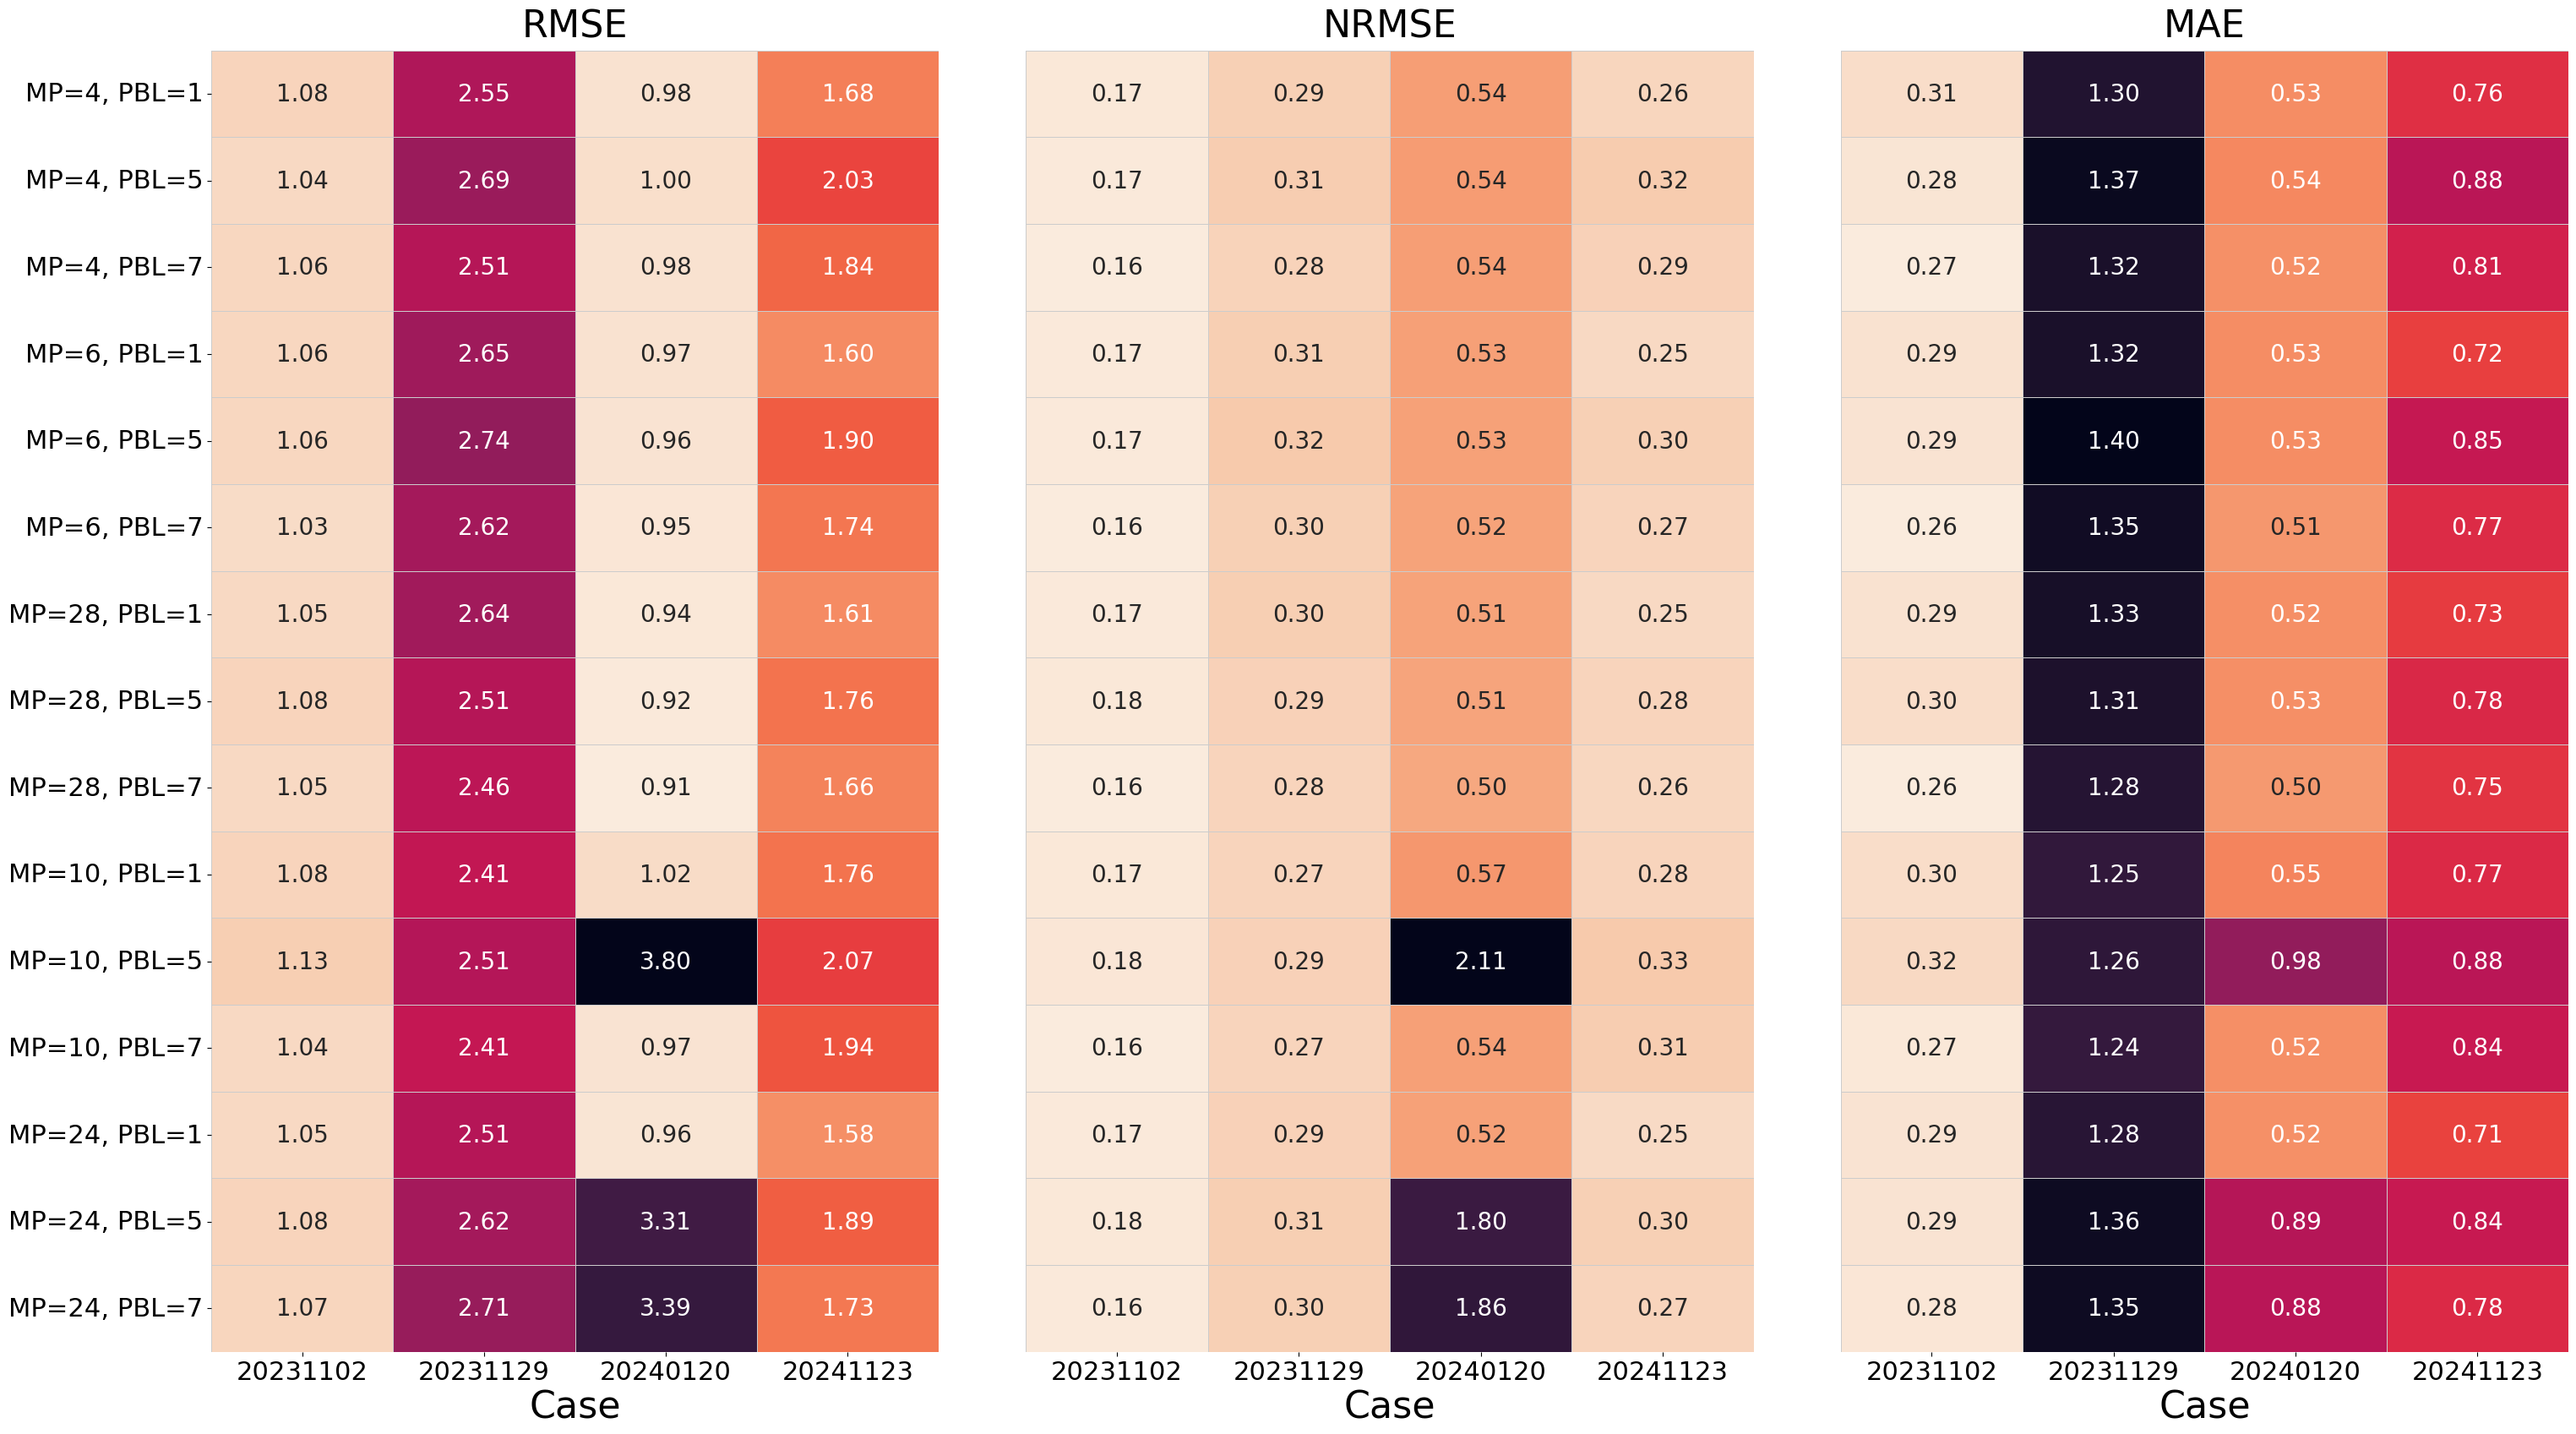

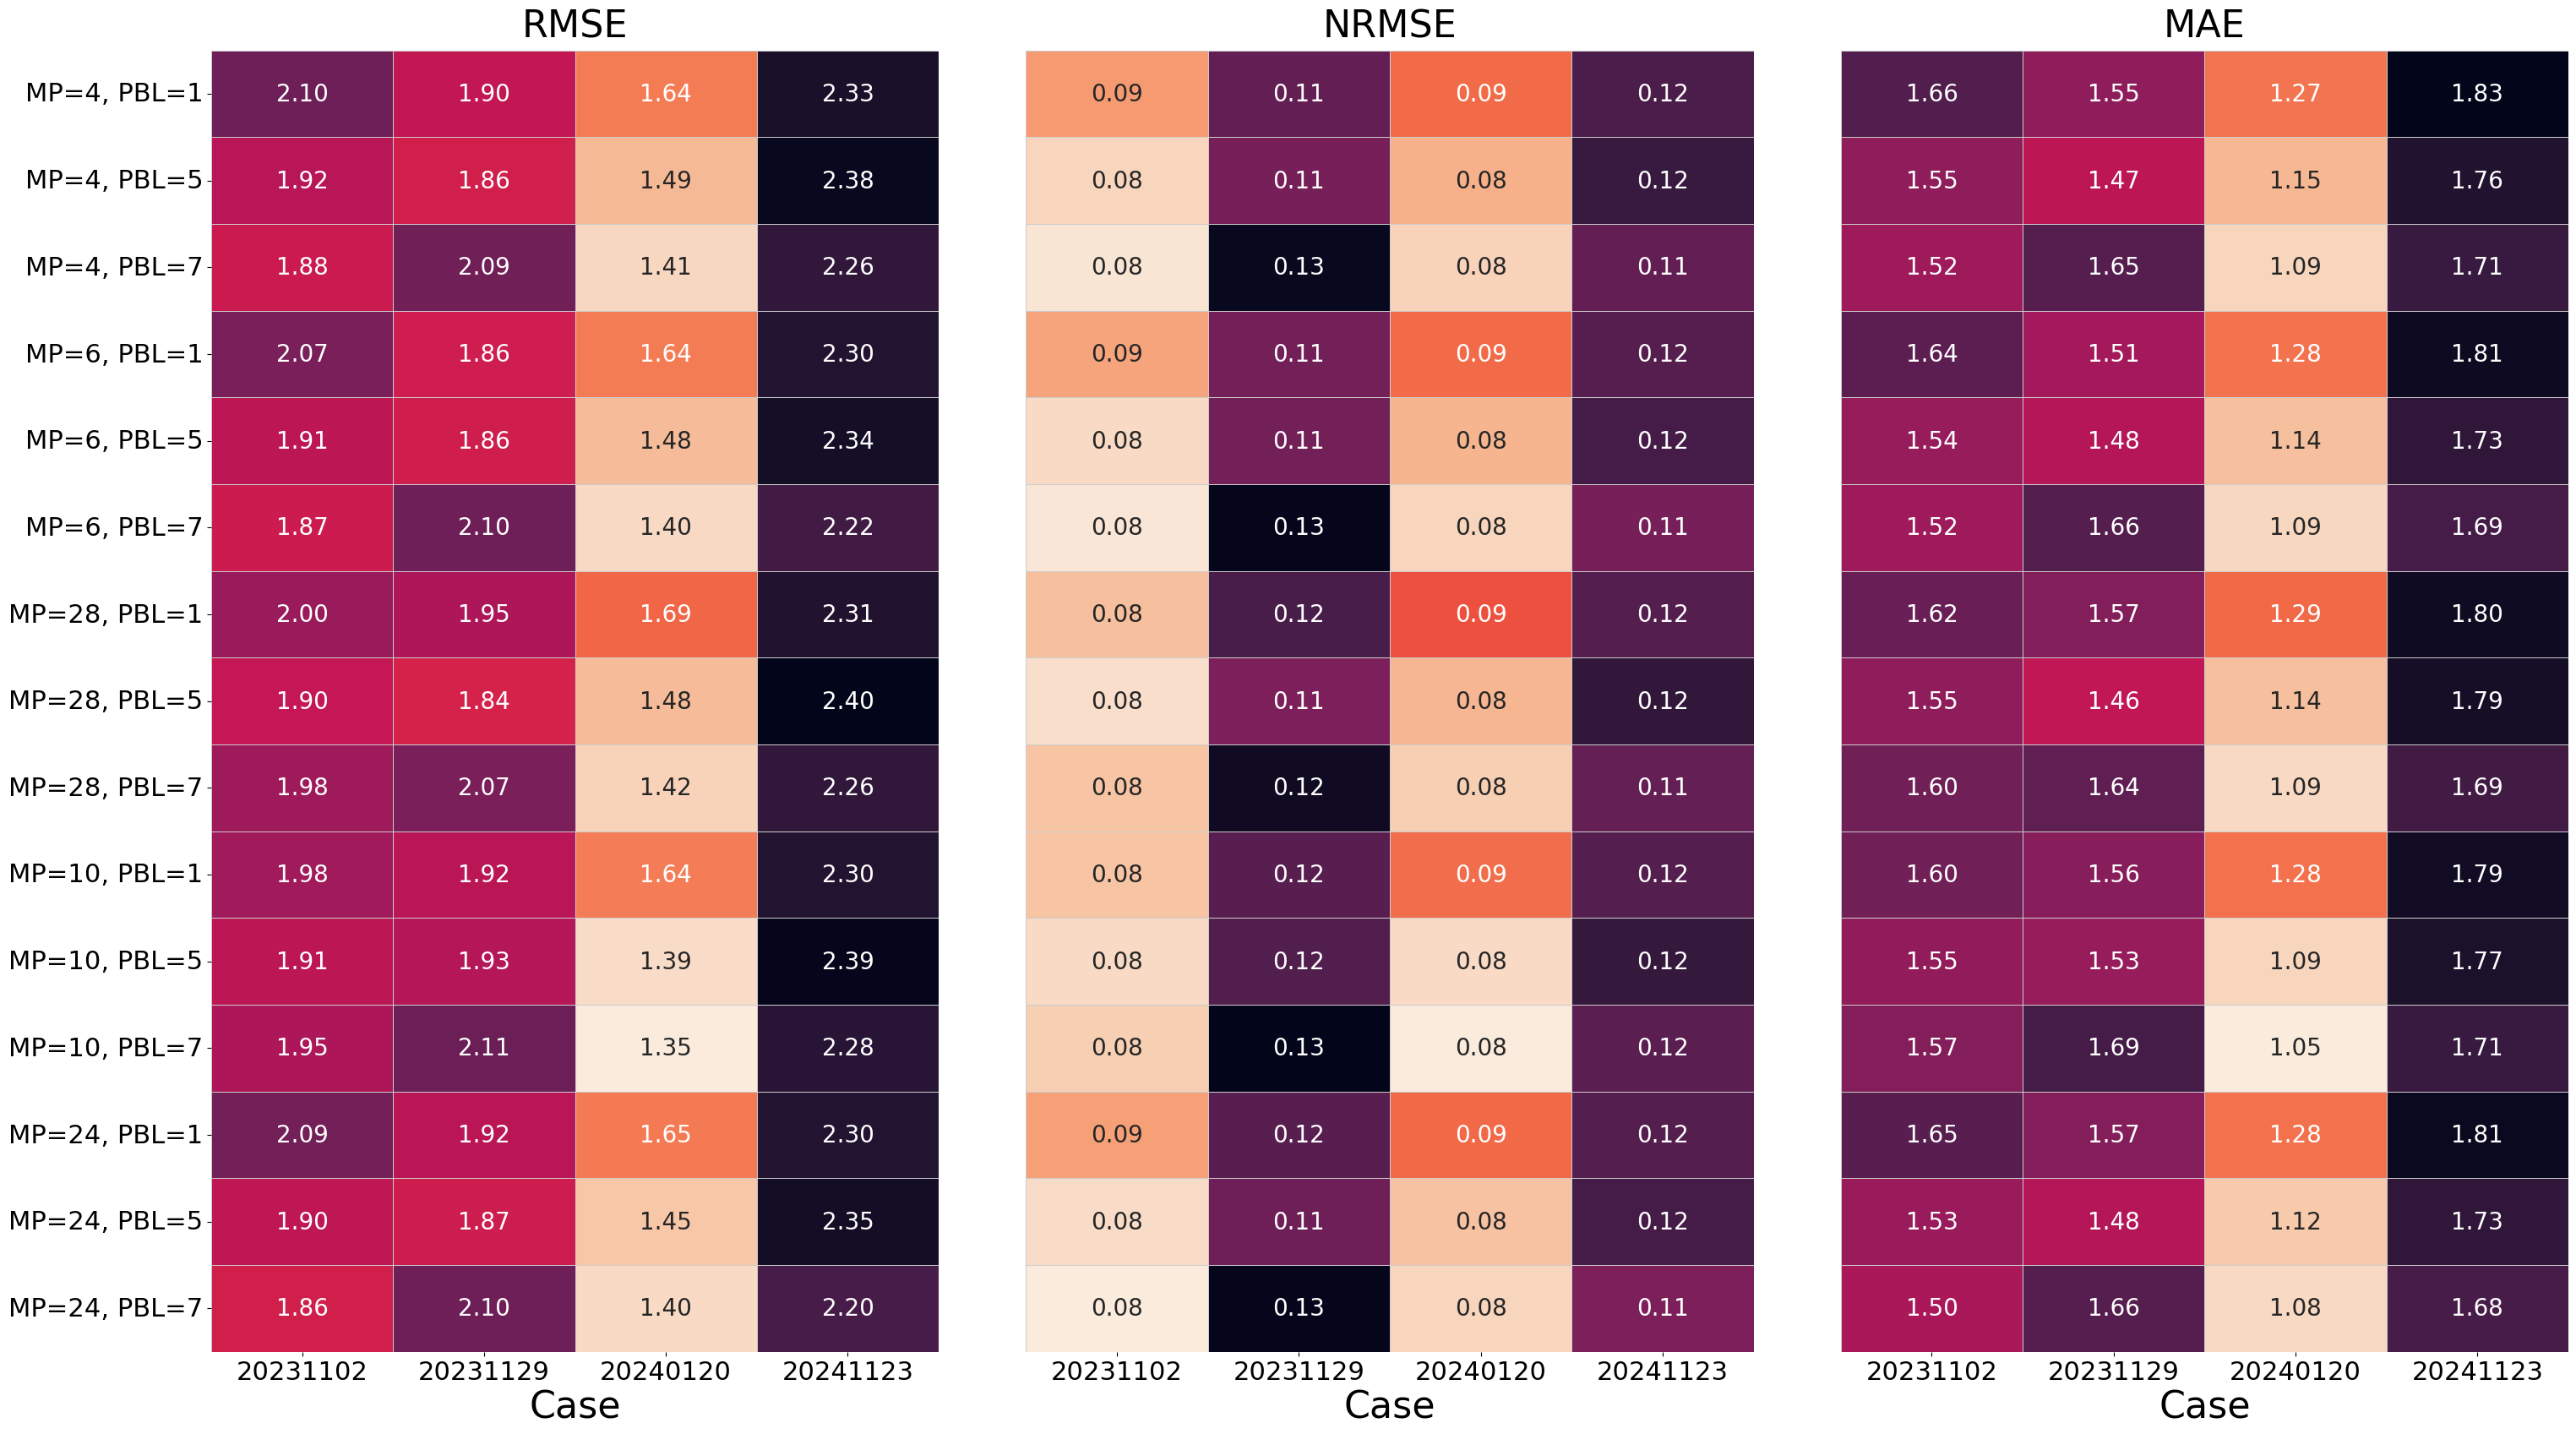

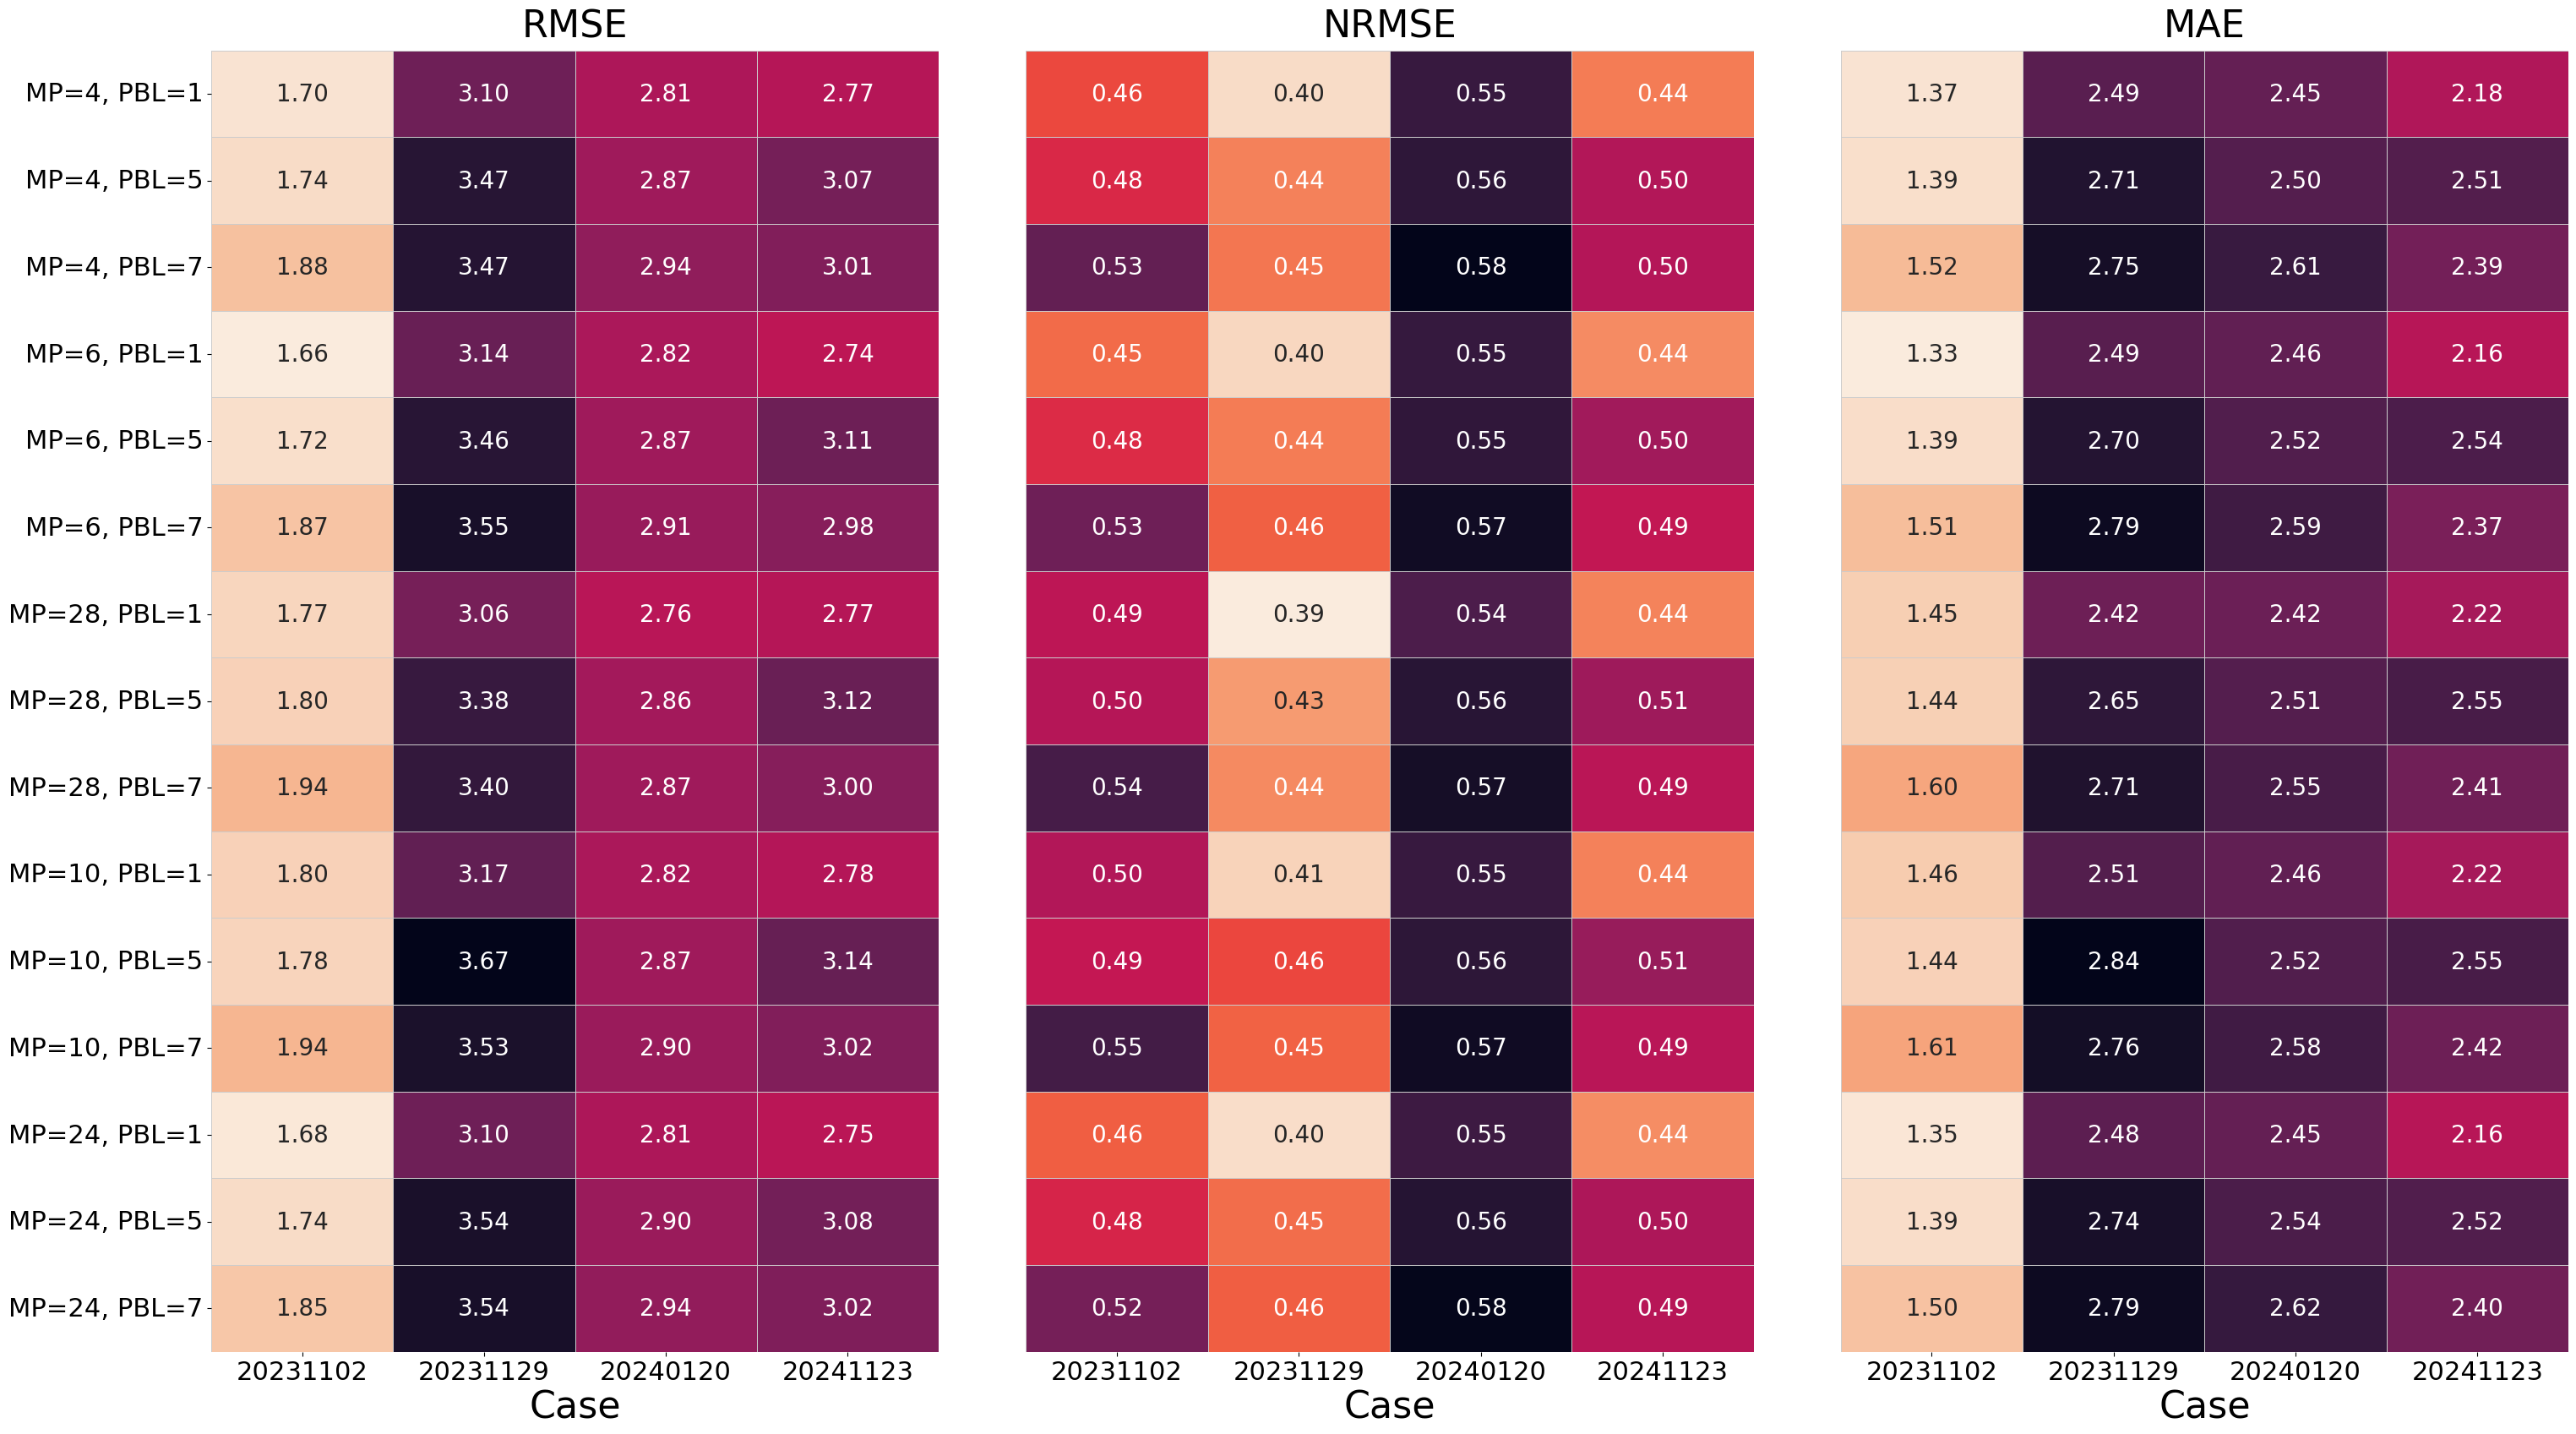

In [22]:
#!/usr/bin/env python3
# errors_heatmap_fixed.py
"""Create per-variable error heat-maps (RMSE, NRMSE, MAE x 4 cases) averaged
over 13 WMO stations for 15 WRF (MP,PBL) runs."""

import os, sys, itertools
from glob import glob
from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ─────────────── SETTINGS ─────────────── #
CASES = ["20231102", "20231129", "20240120", "20241123"]
RUNS  = [(4,1),(4,5),(4,7),(6,1),(6,5),(6,7),
         (28,1),(28,5),(28,7),(10,1),(10,5),(10,7),
         (24,1),(24,5),(24,7)]
RUN_LABELS  = [f"MP={m}, PBL={p}" for m,p in RUNS]
METRICS     = ["RMSE","NRMSE","MAE"]

VAR_MAP_MODEL = {"Yagis(mm)"            :"precip_mm",
                 "2_Metre_Sicaklik(C)"  :"t2_degC",
                 "10_Metre_Ruzgar(m/s)" :"ws10_mps"}
VAR_MAP_OBS   = {"precip_mm":"precip_mm",
                 "t2_degC":"t2_degC",
                 "wdir_ws_deg_mps":"ws10_mps"}

# ─────────────── HELPERS ─────────────── #
def nrmse(pred, obs, eps=1e-12):
    rmse  = np.sqrt(((pred-obs)**2).mean())
    mean_ = obs.max()
    return np.nan if abs(mean_)<eps else rmse/mean_

def metric_values(pred, obs):
    rmse = np.sqrt(((pred-obs)**2).mean())
    return {"RMSE":rmse, "NRMSE":nrmse(pred,obs), "MAE":np.abs(pred-obs).mean()}

def parse_model_filename(p):
    base = os.path.basename(p).split("_")
    return base[1], int(base[2][2:]), int(base[3][3:]), base[5].split(".")[0]  # case, mp, pbl, stid

# ─────────────── DISCOVER FILES ─────────────── #
model_files = glob("csv_files/case_*_mp*_pbl*_station_*.csv")
obs_files   = glob("obs_csvs/*.csv")
if not (model_files and obs_files):
    sys.exit("Model or observation CSVs missing.")

obs_lookup = {}
for f in obs_files:
    base = os.path.basename(f)
    if not (base[:6].isdigit() and "_" in base):
        continue
    yyyymm        = base[:6]
    station_id    = base.split("_")[-1].split(".")[0]
    canonical_var = next((v for t,v in VAR_MAP_OBS.items() if t in base), None)
    if canonical_var:
        obs_lookup[(canonical_var, station_id, yyyymm)] = f

# ─────────────── COLLECT RAW SCORES ─────────────── #
scores = defaultdict(  # var →
           lambda: defaultdict(          # run →
             lambda: defaultdict(        # metric →
               lambda: defaultdict(list) # case → list[float]
           )))

for mp_csv in model_files:
    case, mp, pbl, stid = parse_model_filename(mp_csv)
    run_lbl = f"MP={mp}, PBL={pbl}"

    mod = pd.read_csv(mp_csv, parse_dates=["Tarih"]).rename(columns={"Tarih":"datetime"})
    for col, var in VAR_MAP_MODEL.items():
        if col not in mod.columns: continue
        yyyymm   = case[:6]
        obs_path = obs_lookup.get((var, stid, yyyymm))
        if not obs_path: continue

        obs = (pd.read_csv(obs_path, parse_dates=["datetime"])
                 .rename(columns={"value":var}))

        paired = (mod[["datetime",col]]
                    .merge(obs[["datetime",var]], on="datetime", how="inner")
                    .dropna())
        if paired.empty: continue

        mets = metric_values(paired[col], paired[var])
        for m,v in mets.items():
            if np.isfinite(v):
                scores[var][run_lbl][m][case].append(v)

# ─────────────── BUILD & PLOT HEAT-MAPS ─────────────── #
for var, run_dict in scores.items():
    arrays = [[m for m in METRICS for _ in CASES],
              list(itertools.chain.from_iterable([CASES]*len(METRICS)))]
    cols   = pd.MultiIndex.from_arrays(arrays, names=["Metric", "Case"])
    results = pd.DataFrame(index=RUN_LABELS, columns=cols, dtype=float)

    for run_lbl, m_dict in run_dict.items():
        for m, case_dict in m_dict.items():
            for case, vals in case_dict.items():
                if vals:
                    results.loc[run_lbl, (m, case)] = np.mean(vals)

    # 1⃣  use *either* constrained-layout *or* manual spacing → choose manual
    fig, axes = plt.subplots(
        1, 3,
        figsize=(36, 20),
        sharey=False,
        gridspec_kw={"wspace": 0.12},
    )

    for i, m in enumerate(METRICS):
        metric_df = results.xs(m, level="Metric", axis=1)[CASES]

        sns.heatmap(
            metric_df,
            ax=axes[i],
            annot=True, fmt=".2f",
            annot_kws={"fontsize": 20},  
            linewidths=.4, linecolor="0.8",
            cmap="rocket_r", cbar=False,
            yticklabels=metric_df.index if i == 0 else False
        )

        axes[i].set_title(m, fontsize=32, pad=12)
        axes[i].set_xlabel("Case", fontsize=32)

        axes[i].set_xticklabels(axes[i].get_xticklabels(), ha='center', fontsize=22)

        if i == 0:
            axes[i].set_yticklabels(metric_df.index, rotation=0, fontsize=22)
        else:
            axes[i].set_yticklabels([])

        axes[i].set_ylabel("")

    #fig.suptitle(f"{var} — mean error over 13 stations", fontsize=18, y=0.97)
    out = f"{var}_error_heatmap_grid.png"
    fig.savefig(out, dpi=300)
    print(f"saved → {out}")

In [65]:
scores["precip_mm"]["MP=38, PBL=1"]["RMSE"]["20240120"]

[0.9931711276959722,
 1.3341664064126333,
 0.8629728977333079,
 0.8285697181153665,
 0.8950481054731702,
 0.9084480049941096,
 0.8955135088006458,
 0.8532617157446802,
 0.8259674462242579,
 0.8852181149926334,
 0.8924062353485037,
 0.9931711276959722,
 0.9931711276959722]

In [64]:
model_files[50]

'csv_files/case_20240120_mp38_pbl1_station_18396.csv'

In [51]:
col = "Yagis(mm)"
var = "precip_mm"

yyyymm   = case[:6]
obs_path = obs_lookup.get((var, stid, yyyymm))



In [52]:
obs = (pd.read_csv(obs_path, parse_dates=["datetime"])
            .rename(columns={"value":var}))

paired = (mod[["datetime",col]]
            .merge(obs[["datetime",var]], on="datetime", how="inner")
            .dropna())

mets = metric_values(paired[col], paired[var])
for m,v in mets.items():
    if np.isfinite(v):
        scores[var][run_lbl][m][case].append(v)

In [63]:
paired

,datetime,Yagis(mm),precip_mm
0,2024-01-19 00:00:00,0,0.0
1,2024-01-19 01:00:00,0,0.1
2,2024-01-19 02:00:00,0,0.0
3,2024-01-19 03:00:00,0,0.0
4,2024-01-19 04:00:00,0,0.0
...,...,...,...
67,2024-01-21 19:00:00,0,1.1
68,2024-01-21 20:00:00,0,0.7
69,2024-01-21 21:00:00,0,1.0
70,2024-01-21 22:00:00,0,0.4


In [66]:
VAR_TITLE_VAR = {"precip_mm"            :"Hourly Precipitation",
                 "t2_degC"              :"Temperature",
                 "wdir_ws_deg_mps"      :"Wind Speed"}

In [67]:
VAR_TITLE_VAR["precip_mm"]

'Hourly Precipitation'

In [57]:
pd.set_option('display.max_rows', None)
print(paired)
pd.reset_option('display.max_rows')

              datetime  Yagis(mm)  precip_mm
0  2024-01-19 00:00:00          0        0.0
1  2024-01-19 01:00:00          0        0.1
2  2024-01-19 02:00:00          0        0.0
3  2024-01-19 03:00:00          0        0.0
4  2024-01-19 04:00:00          0        0.0
5  2024-01-19 05:00:00          0        0.0
6  2024-01-19 06:00:00          0        0.0
7  2024-01-19 07:00:00          0        0.0
8  2024-01-19 08:00:00          0        0.0
9  2024-01-19 09:00:00          0        0.0
10 2024-01-19 10:00:00          0        0.0
11 2024-01-19 11:00:00          0        0.0
12 2024-01-19 12:00:00          0        0.2
13 2024-01-19 13:00:00          0        0.0
14 2024-01-19 14:00:00          0        0.0
15 2024-01-19 15:00:00          0        0.0
16 2024-01-19 16:00:00          0        0.0
17 2024-01-19 17:00:00          0        0.0
18 2024-01-19 18:00:00          0        0.0
19 2024-01-19 19:00:00          0        0.0
20 2024-01-19 20:00:00          0        0.0
21 2024-01

In [58]:
np.sqrt(((paired["precip_mm"]-paired["Yagis(mm)"])**2).mean())

0.9931711276959722

# Timeseries

In [2]:
sets_mapping = pd.DataFrame([
    {"set_name": "SET1", "physics": "mp4_pbl1"},
    {"set_name": "SET2", "physics": "mp4_pbl5"},
    {"set_name": "SET3", "physics": "mp4_pbl7"},
    {"set_name": "SET4", "physics": "mp6_pbl1"},
    {"set_name": "SET5", "physics": "mp6_pbl5"},
    {"set_name": "SET6", "physics": "mp6_pbl7"},
    {"set_name": "SET7", "physics": "mp28_pbl1"},
    {"set_name": "SET8", "physics": "mp28_pbl5"},
    {"set_name": "SET9", "physics": "mp28_pbl7"},
    {"set_name": "SET10", "physics": "mp10_pbl1"},
    {"set_name": "SET11", "physics": "mp10_pbl5"},
    {"set_name": "SET12", "physics": "mp10_pbl7"},
    {"set_name": "SET13", "physics": "mp24_pbl1"},
    {"set_name": "SET14", "physics": "mp24_pbl5"},
    {"set_name": "SET15", "physics": "mp24_pbl7"},
])

case = "20241123"
station_id = "17061"
csv_files_path = os.path.join(os.getcwd(), "csv_files")

matching_files = []
df = {}

if os.path.isdir(csv_files_path):
    for filename in os.listdir(csv_files_path):
        if filename.startswith(f"case_{case}") and filename.endswith(f"{station_id}.csv"):
            matching_files.append(os.path.join(csv_files_path, filename))

for file in matching_files:
    physics = file.split(f"case_{case}")[1].split("_station")[0].lstrip("_")
    set_name = sets_mapping.loc[sets_mapping["physics"] == physics, "set_name"].values[0]
    df[set_name] = pd.read_csv(file)

In [4]:
plot_timeseries_15(case = case, station_id = station_id, variable = "tp", fig_path = os.path.join(os.getcwd(), "figures", case))

IndexError: index 0 is out of bounds for axis 0 with size 0